# Capstone Project Pneumonia Image Recognition with CNN and tensorflow

# Problem Statement
How can images of infant chest X Rays be viewed algorithmically such that Pneumonia can be detected from Normal conditions with a level of confidence above 90%?

A Deep Learning algorithm of Convolution Neural Networks will be applied to images of pediatric X Rays separated into Pneumonia and Normal groups to determine if images can predict results based on training a model on the dataset

Images from the Kaggle Dataset: Pediatric Phneumonia Chest X-ray
https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray

Code references from Towards Data Science: https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Dataset by Daniel Kermany and Michael Goldbaum in 2018.  The data includes 5,856 images labelled as either pneumonia or normal 

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

In [1]:
# typical imports
import os
import random
import shutil
import sys

import matplotlib.pyplot as plt  # To visualize data
import numpy as np               # For arrays
import pandas as pd              # For holding and handling data
import seaborn as sns            # for confusion matrix plotting
from sklearn.metrics import accuracy_score, plot_confusion_matrix   # for metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score  # for metrics

# image processing imports
import cv2                       # For image to file handling
import glob                      # to read all files in directory

# for preprocessing the images
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,History
history = History()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

# for reading images from folders
from tensorflow.keras.preprocessing.image import DirectoryIterator  


# Load the data

In [2]:
# Define Overall Structure for modeling
# Directories for train, test, and validation datasets
source_data_path = 'CS_Pneumonia/source_data'
dataset_path = 'CS_Pneumonia/results_data'

# Batch size is number of trainging examples per iteration
batch_size = 20

# Dimension size of images set as 300x300 to limit loading on CPU of machine
img_height = 300
img_width = 300

In [3]:
# Identify the categorization and folder names for this dataset
categories = ['NORMAL','PNEUMONIA']
folders = ['train', 'test', 'valid']

# Exploratory Data Analysis

In [4]:
#Evaluate the pictures in the source folder
# read all files using glob method and record their features in DataFrame
file_list = []
for f in folders:                                 # train, test, or valid
    for c in categories:                          # pneumonia, normal
        for n in glob.glob(source_data_path+'/'+f+'/'+c+'/*.jpeg'):
            img = cv2.imread(n)
            # cv2.shape provides information for each image as 
            #height, width, number of channels of image
            width = img.shape[1]      # width
            height = img.shape[0]      # height
            ratio = height/width
            file_name = os.path.basename(n)
            info = [file_name,f,c,width,height,ratio]
            file_list.append(info)
                
print("pictures in database for modeling: ",len(file_list))
df_pics = pd.DataFrame(file_list)
df_pics.columns = ['File','Data Set','Result','Width','Height','Ratio']
df_pics.head()

pictures in database for modeling:  5856


,File,Data Set,Result,Width,Height,Ratio
0,NORMAL2-IM-0927-0001.jpeg,train,NORMAL,2359,2234,0.947011
1,NORMAL2-IM-1056-0001.jpeg,train,NORMAL,1422,1067,0.750352
2,IM-0427-0001.jpeg,train,NORMAL,1828,1357,0.742341
3,NORMAL2-IM-1260-0001.jpeg,train,NORMAL,1854,1495,0.806365
4,IM-0656-0001-0001.jpeg,train,NORMAL,2194,1966,0.896080


In [5]:
# Determine the typical ratio of Height/Width for the dataset
df_pics['Ratio'].describe()

count    5856.000000
mean        0.712905
std         0.117312
min         0.295964
25%         0.630616
50%         0.706272
75%         0.792627
max         1.197044
Name: Ratio, dtype: float64

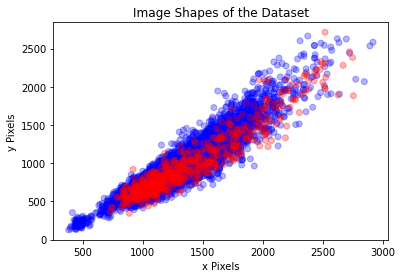

In [6]:
# Scatterplot of Width and Height parameters to show sizing
colors = df_pics['Data Set'].map({'train':'b', 'test':'r'})
fig, ax = plt.subplots()
ax.scatter(df_pics['Width'],df_pics['Height'],c=colors, alpha=0.3)
ax.set_xlabel("x Pixels")
ax.set_ylabel("y Pixels")
ax.set_title("Image Shapes of the Dataset")
plt.show()

In [7]:
# method to load files from source s_path to d_path, using cat for folder structure within
# changes images to grayscale and crops to width (w) x height (h) pixel size
# returns image array with label array aligned
def load_images(s_path,d_path,cat,w,h,min_size):
    ''' load_images moves files from source path string (s_path) to dest path string (d_path)
    making the images grayscale and resized to pixel count for height (h) by width (w)abs
    Exclusions for minimum pixel size (min_size), cat is category sub folder'''

    counter = 0
    fold = ['train','test']
    destination_path = d_path+'/'+cat
    for f in fold:
        source = s_path + '/' + f + '/' + cat
        print("Load Images Method: From ",source," to ",destination_path)        
        for file in glob.glob(source+'/*.jpeg'):
            img = cv2.imread(file)
            # compare image params, only resize and move if file meets size conditions
            if (img.shape[1] > min_size) and (img.shape[0] > min_size): 
                counter += 1
                
                file_name = os.path.basename(file)
                cv2.imwrite(destination_path+'/'+file_name,img)
    print("Files copied: ",counter," into ",cat)
    return counter

# Data Wrangling

In [8]:
# Establish destination directory folders
for f in folders:
    if not os.path.exists(dataset_path+'/'+f):
        os.makedirs(dataset_path+'/'+f)
    for c in categories:
        if not os.path.exists(dataset_path+'/'+f+'/'+c):
            os.makedirs(dataset_path+'/'+f+'/'+c)

In [9]:
# Load all the images from source folder into train folder. 
#(Combine both source test and train)
# Establish limits for files to be included in model
min_size = 200
    
norm_counts = load_images(source_data_path,dataset_path+'/train','NORMAL',img_width,img_height,min_size)
print("Normal Images in data folder: ",norm_counts)
pneu_counts = load_images(source_data_path,dataset_path+'/train','PNEUMONIA',img_width,img_height,min_size)
print("Pneumonia Images in data folder: ",pneu_counts)

Load Images Method: From  CS_Pneumonia/source_data/train/NORMAL  to  CS_Pneumonia/results_data/train/NORMAL
Load Images Method: From  CS_Pneumonia/source_data/test/NORMAL  to  CS_Pneumonia/results_data/train/NORMAL
Files copied:  1583  into  NORMAL
Normal Images in data folder:  1583
Load Images Method: From  CS_Pneumonia/source_data/train/PNEUMONIA  to  CS_Pneumonia/results_data/train/PNEUMONIA
Load Images Method: From  CS_Pneumonia/source_data/test/PNEUMONIA  to  CS_Pneumonia/results_data/train/PNEUMONIA
Files copied:  4240  into  PNEUMONIA
Pneumonia Images in data folder:  4240


In [10]:
# Move images into Test, Train, Valid folders
# Determine smallest group size, then take 10 percent for target valid,test files 
percent10 = min(norm_counts,pneu_counts)//10

check_folders = ['test','valid']
for f in check_folders:
    for c in categories:
        print('checking  ',dataset_path + '/train/' + c)
        for i in range(percent10):
            src = dataset_path + '/train/' + c
            dest = dataset_path + '/' + f + '/' + c
            random_file = random.choice(os.listdir(src))
            source_file = src + '/' + random_file
            shutil.move(source_file,dest)
        print('Moved ',i,'files from',src,' to ',dest)

# move extra files to discard folder

num_norm_files = len([f for f in os.listdir(dataset_path+'/train/NORMAL')if os.path.isfile(os.path.join(dataset_path+'/train/NORMAL', f))])
num_pneu_files = len([f for f in os.listdir(dataset_path+'/train/PNEUMONIA')if os.path.isfile(os.path.join(dataset_path+'/train/PNEUMONIA', f))])
print("Files remaining- NORMAL:",num_norm_files,". PNEUMONIA:",num_pneu_files)

if not os.path.exists(dataset_path + '/discard'):
        os.makedirs(dataset_path + '/discard')


checking   CS_Pneumonia/results_data/train/NORMAL
Moved  157 files from CS_Pneumonia/results_data/train/NORMAL  to  CS_Pneumonia/results_data/test/NORMAL
checking   CS_Pneumonia/results_data/train/PNEUMONIA
Moved  157 files from CS_Pneumonia/results_data/train/PNEUMONIA  to  CS_Pneumonia/results_data/test/PNEUMONIA
checking   CS_Pneumonia/results_data/train/NORMAL
Moved  157 files from CS_Pneumonia/results_data/train/NORMAL  to  CS_Pneumonia/results_data/valid/NORMAL
checking   CS_Pneumonia/results_data/train/PNEUMONIA
Moved  157 files from CS_Pneumonia/results_data/train/PNEUMONIA  to  CS_Pneumonia/results_data/valid/PNEUMONIA
Files remaining- NORMAL: 1267 . PNEUMONIA: 3924


In [11]:
# The remaining folder "/train/PNEUMONIA" has signficantly more files than "/train/NORMAL"
count=int((num_pneu_files - num_norm_files)*.8)
for i in range(count):
    src = dataset_path +'/train/PNEUMONIA'
    dest = dataset_path + '/discard'
    random_file = random.choice(os.listdir(src))
    source_file = src + '/' + random_file
    shutil.move(source_file,dest)
print('Moved ',i,'files from',src,' to ',dest)

Moved  2124 files from CS_Pneumonia/results_data/train/PNEUMONIA  to  CS_Pneumonia/results_data/discard


# Image Preprocessing
Read all images convert to Grayscale, size, prep for model

In [12]:
# Data PreProcessing
def image_preprocess(path):
    # Start empty list of each category (path) called
    images = []
    for i in path:
        # read the image
        img = cv2.imread(i)
        # resize
        img = cv2.resize(img,
                         dsize = (img_height,img_width), 
                         interpolation = cv2.INTER_CUBIC)
        # adjust brightness, contrast
        alpha = 1.0      # contrast
        beta = 1.0       # brightness
        img = cv2.addWeighted(img,
                              alpha,
                              np.zeros(img.shape, img.dtype),
                              0,beta)
        # convert grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
        # Normalize the images 
        img = cv2.bitwise_not(img)
        img = img/255
        # append onto list of images
        images.append(img)
    # return the filled list of images
    return images

In [13]:
# Read files into the folders with preprocessing applied, observe image counts
# counts are [normal,pneumonia]
train_img_count, test_img_count, valid_img_count = [0,0], [0,0], [0,0]

# Training
img_train_normal = image_preprocess(path=glob.glob(dataset_path+"/train/NORMAL/*.jpeg"))
train_img_count[0] = len(img_train_normal)
img_train_pneumonia = image_preprocess(path=glob.glob(dataset_path+"/train/PNEUMONIA/*.jpeg"))
train_img_count[1] = len(img_train_pneumonia)

# Testing
img_test_normal = image_preprocess(path=glob.glob(dataset_path+"/test/NORMAL/*.jpeg"))
test_img_count[0] = len(img_test_normal)
img_test_pneumonia = image_preprocess(path=glob.glob(dataset_path+"/test/PNEUMONIA/*.jpeg"))
test_img_count[1] = len(img_test_pneumonia)

# Validation
img_valid_normal = image_preprocess(path=glob.glob(dataset_path+"/valid/NORMAL/*.jpeg"))
valid_img_count[0] = len(img_valid_normal)
img_valid_pneumonia = image_preprocess(path=glob.glob(dataset_path+"/valid/PNEUMONIA/*.jpeg"))
valid_img_count[1] = len(img_valid_pneumonia)

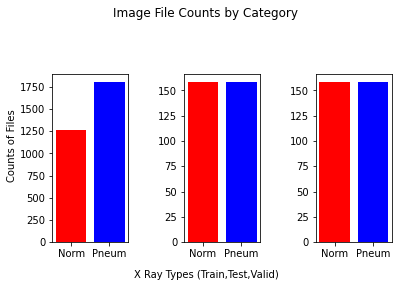

In [14]:
# Review file counts for all categories
fig, ax = plt.subplots(1, 3)
fig.suptitle('Image File Counts by Category')

#ax[0].set_color('r')
ax[0].bar(['Norm','Pneum'],train_img_count, color=['r','b'])
ax[1].bar(['Norm','Pneum'],test_img_count, color=['r','b'])
ax[2].bar(['Norm','Pneum'],valid_img_count, color=['r','b'])
fig.tight_layout(pad=3.0)
fig.text(0.5,0.04,'X Ray Types (Train,Test,Valid)', ha='center')
fig.text(0.04,0.5, 'Counts of Files', va='center', rotation='vertical')
plt.show()

In [15]:
# Create labels for the images
# Training
y_train_normal = [0 for i in range(0,len(img_train_normal))]
y_train_pneumonia = [1 for i in range(0,len(img_train_pneumonia))]
# Testing
y_test_normal = [0 for i in range(0,len(img_test_normal))]
y_test_pneumonia = [1 for i in range(0,len(img_test_pneumonia))]
# Validation
y_valid_normal = [0 for i in range(0,len(img_valid_normal))]
y_valid_pneumonia = [1 for i in range(0,len(img_valid_pneumonia))]

In [16]:
# Define  X_train, X_test, y_train, y_test for analysis
X_train = np.concatenate((img_train_normal, img_train_pneumonia), axis = 0)
X_test = np.concatenate((img_test_normal, img_test_pneumonia), axis = 0)
X_valid = np.concatenate((img_valid_normal, img_valid_pneumonia), axis = 0)
y_train = np.concatenate((y_train_normal, y_train_pneumonia), axis = 0)
y_test = np.concatenate((y_test_normal, y_test_pneumonia), axis = 0)
y_valid = np.concatenate((y_valid_normal, y_valid_pneumonia), axis = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(3066, 300, 300)
(3066,)
(316, 300, 300)
(316,)
(316, 300, 300)
(316,)


In [17]:
# Create method to accept X,y arrays, shuffle the order
# Then return arrays that maintain labels and are randomized, return as np.array
def shuffle_label_array(arrays,labels):
    org_images = []
    for i,j in enumerate(arrays):
        # brings images and labels together into same array
        new_array = (j,labels[i])
        org_images.append(new_array)  # append onto the array
    temp_array = np.array(org_images)
    np.random.shuffle(temp_array)     # shuffle the array
# Now split back apart keeping the order association for separate lists
    X_data = []                    # temporary X array
    y_data = []                    # temporary y array
    for a in temp_array:
        # pull images and labels apart
        X_data.append(a[0])        # image
        y_data.append(a[1])        # label
    return np.array(X_data), np.array(y_data)

# Modeling

# CNN Model Build
Convolutional layers: (input data image with 2D convolutional layers) Creates feature map. Depth of filter same as depth of input- grayscale is 1.  Will apply a Sequential model to allow us to build layer by layer

Determining the dimension of activation maps:
(N + 2P — F)/ S + 1; where N = Dimension of image (input) file
P = Padding
F = Dimension of filter
S = Stride

ReLu layers: (Rectified Linear Unit - linear function to output directly if positive, otherwise zero) Increases non-linearity. _Better than Sigmoid and Tanh based on overcoming the vanishing gradient problem.

Pooling layers: Combine to create spatial variance, make objects detectable no matter where they are located in the image

Flattening: make long vector of pooled features

Fully connect layer: Input vector into neural network.  Process features through the network.  The fully connected layers votes on the classes

Train the model: using forward propagation and backpropagation, trains the neural network with weights and feature detectors


In [18]:
# Define lists to hold model results for each run
accuracy, precision, recall, f1 = [],[],[],[]

In [19]:
# Method to Display results for model
def model_results(m,xt,yt):    # m-model, xt-X_test data, yt- y_test labels

    print('*****  RESULTS  *****')
    #model_results(model,test_data,test_labels,valid)
    print("test data set size: ",len(xt))
    predictions = m.predict(xt)
    # turn predictions into 0 and 1 values. Sigmoid output is 0 to 1 so split on 0.5
    predictions_values = []
    for i in predictions:
        if i < 0.54:
            predictions_values.append(0)
        if i >= 0.54:
            predictions_values.append(1)

    # Plot confusion matrix
    print('*****  Confusion Matrix  *****')
    cm = confusion_matrix(yt, predictions_values)
    print(cm)

    print('*****  Classification Report  *****')
    print(classification_report(yt,predictions_values,target_names=categories))

    print('*****  Metric Scores  *****')
    # accuracy: (tp + tn_ / (p + n)
    accuracy = accuracy_score(yt,predictions_values)
    # precision: tp / (tp + fp)
    precision = precision_score(yt,predictions_values)
    # recall: tp / (tp + fn)
    recall = recall_score(yt,predictions_values)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(yt,predictions_values)
    
    # display results
    print('Accuracy : ',f'{accuracy:.3f}')
    print('Precision : ',f'{precision:.3f}')
    print('Recall   : ',f'{recall:.3f}')
    print('F1 score : ',f'{f1:.3f}')
    # show heatmap of confusion matrix
    print('*****  Heat Map of Confusion Matrix  *****')
    sns.heatmap(cm, cbar=False, xticklabels=categories, yticklabels=categories, fmt='d', annot=True, cmap=plt.cm.Reds)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print('*****  Metrics Results  *****')
    return accuracy, precision, recall, f1

# Create model

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 93s 969ms/step - loss: 0.3310 - accuracy: 0.8431 - val_loss: 0.3201 - val_accuracy: 0.8544
Epoch 2/25
96/96 [==============================] - 91s 949ms/step - loss: 0.1707 - accuracy: 0.9361 - val_loss: 0.1630 - val_accuracy: 0.9335
Epoch 3/25
96/96 [==============================] - 93s 968ms/step - loss: 0.1537 - accuracy: 0.9452 - val_loss: 0.1207 - val_accuracy: 0.9462
Epoch 4/25
96/96 [==============================] - 93s 969ms/step - loss: 0.1438 - accuracy: 0.9488 - val_loss: 0.1133 - val_accuracy: 0.9525
Epoch 5/25
96/96 [==============================] - 92s 964ms/step - loss: 0.1227 - accuracy: 0.9547 - val_loss: 0.1300 - val_accuracy: 0.9367
Epoch 6/25
96/96 [==============================] - 91s 950ms/step - loss: 0.1068 - accuracy: 0.9599 - val_loss: 0.1029 - val_accuracy: 0.9462
Epoch 7/25
96/96 [==============================] - 89s 929ms/step - loss: 0.0848 - accuracy: 0.9690 - val_loss: 0.1305 - val_accuracy: 0.9430

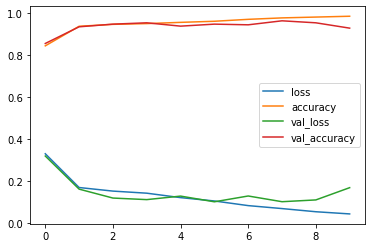

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[140  18]
 [  4 154]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.97      0.89      0.93       158
   PNEUMONIA       0.90      0.97      0.93       158

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316

*****  Metric Scores  *****
Accuracy :  0.930
Precision :  0.895
Recall   :  0.975
F1 score :  0.933
*****  Heat Map of Confusion Matrix  *****


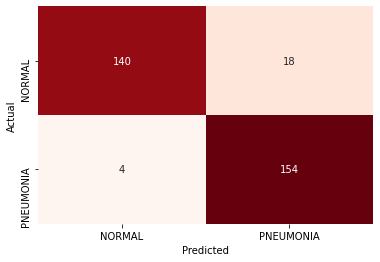

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 91s 946ms/step - loss: 0.3580 - accuracy: 0.8164 - val_loss: 0.1893 - val_accuracy: 0.9272
Epoch 2/25
96/96 [==============================] - 90s 939ms/step - loss: 0.1774 - accuracy: 0.9328 - val_loss: 0.1543 - val_accuracy: 0.9399
Epoch 3/25
96/96 [==============================] - 90s 937ms/step - loss: 0.1482 - accuracy: 0.9491 - val_loss: 0.1047 - val_accuracy: 0.9557
Epoch 4/25
96/96 [==============================] - 90s 935ms/step - loss: 0.1236 - accuracy: 0.9569 - val_loss: 0.1993 - val_accuracy: 0.9082
Epoch 5/25
96/96 [==============================] - 92s 961ms/step - loss: 0.1035 - accuracy: 0.9638 - val_loss: 0.1666 - val_accuracy: 0.9304
Epoch 6/25
96/96 [==============================] - 92s 945ms/step - loss: 0.1085 - accuracy: 0.9602 - val_loss: 0.1482 - val_accuracy: 0.9241
Epoch 7/25
96/96 [==============================] - 91s 952ms/step - loss: 0.0745 - accuracy: 0.9749 - val_loss: 0.1208 - val_accuracy: 0.9367

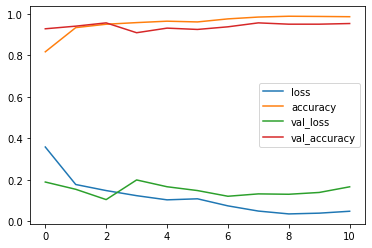

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[144  14]
 [  7 151]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.95      0.91      0.93       158
   PNEUMONIA       0.92      0.96      0.93       158

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316

*****  Metric Scores  *****
Accuracy :  0.934
Precision :  0.915
Recall   :  0.956
F1 score :  0.935
*****  Heat Map of Confusion Matrix  *****


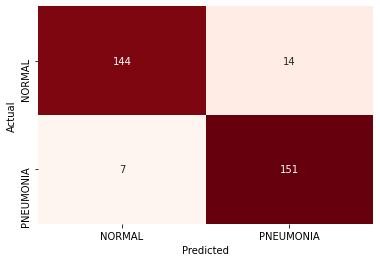

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 96s 998ms/step - loss: 0.4675 - accuracy: 0.7642 - val_loss: 0.1559 - val_accuracy: 0.9304
Epoch 2/25
96/96 [==============================] - 89s 925ms/step - loss: 0.1732 - accuracy: 0.9387 - val_loss: 0.1652 - val_accuracy: 0.9272
Epoch 3/25
96/96 [==============================] - 91s 944ms/step - loss: 0.1540 - accuracy: 0.9446 - val_loss: 0.1172 - val_accuracy: 0.9494
Epoch 4/25
96/96 [==============================] - 91s 946ms/step - loss: 0.1431 - accuracy: 0.9504 - val_loss: 0.1412 - val_accuracy: 0.9399
Epoch 5/25
96/96 [==============================] - 91s 951ms/step - loss: 0.1156 - accuracy: 0.9589 - val_loss: 0.1650 - val_accuracy: 0.9272
Epoch 6/25
96/96 [==============================] - 90s 936ms/step - loss: 0.1035 - accuracy: 0.9622 - val_loss: 0.1745 - val_accuracy: 0.9146
Epoch 7/25
96/96 [==============================] - 90s 938ms/step - loss: 0.0885 - accuracy: 0.9687 - val_loss: 0.0955 - val_accuracy: 0.9652

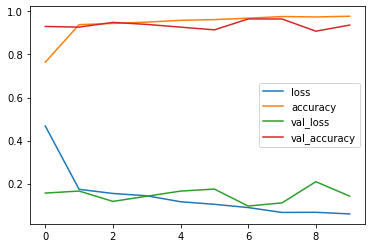

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[144  14]
 [  6 152]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.96      0.91      0.94       158
   PNEUMONIA       0.92      0.96      0.94       158

    accuracy                           0.94       316
   macro avg       0.94      0.94      0.94       316
weighted avg       0.94      0.94      0.94       316

*****  Metric Scores  *****
Accuracy :  0.937
Precision :  0.916
Recall   :  0.962
F1 score :  0.938
*****  Heat Map of Confusion Matrix  *****


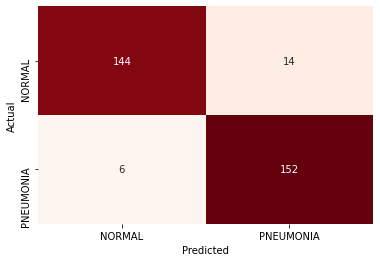

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 94s 976ms/step - loss: 0.4506 - accuracy: 0.7789 - val_loss: 0.1926 - val_accuracy: 0.9241
Epoch 2/25
96/96 [==============================] - 91s 949ms/step - loss: 0.1870 - accuracy: 0.9318 - val_loss: 0.1484 - val_accuracy: 0.9399
Epoch 3/25
96/96 [==============================] - 90s 940ms/step - loss: 0.1719 - accuracy: 0.9367 - val_loss: 0.2017 - val_accuracy: 0.9146
Epoch 4/25
96/96 [==============================] - 92s 960ms/step - loss: 0.1466 - accuracy: 0.9390 - val_loss: 0.1328 - val_accuracy: 0.9367

**************************************************
**********. Model run #:  3   **********


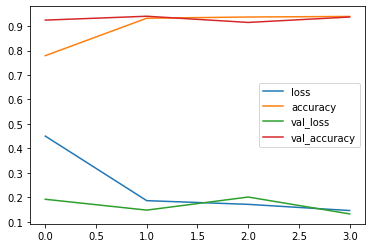

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[144  14]
 [  7 151]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.95      0.91      0.93       158
   PNEUMONIA       0.92      0.96      0.93       158

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316

*****  Metric Scores  *****
Accuracy :  0.934
Precision :  0.915
Recall   :  0.956
F1 score :  0.935
*****  Heat Map of Confusion Matrix  *****


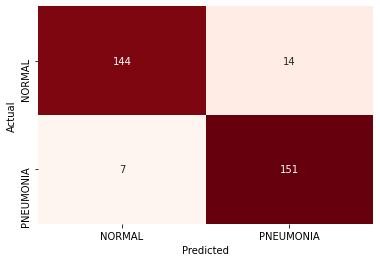

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 91s 942ms/step - loss: 0.3850 - accuracy: 0.8157 - val_loss: 0.2597 - val_accuracy: 0.9019
Epoch 2/25
96/96 [==============================] - 92s 956ms/step - loss: 0.1779 - accuracy: 0.9338 - val_loss: 0.1326 - val_accuracy: 0.9494
Epoch 3/25
96/96 [==============================] - 92s 956ms/step - loss: 0.1435 - accuracy: 0.9481 - val_loss: 0.1152 - val_accuracy: 0.9652
Epoch 4/25
96/96 [==============================] - 92s 963ms/step - loss: 0.1280 - accuracy: 0.9566 - val_loss: 0.1191 - val_accuracy: 0.9715
Epoch 5/25
96/96 [==============================] - 92s 956ms/step - loss: 0.1255 - accuracy: 0.9560 - val_loss: 0.1383 - val_accuracy: 0.9462

**************************************************
**********. Model run #:  4   **********


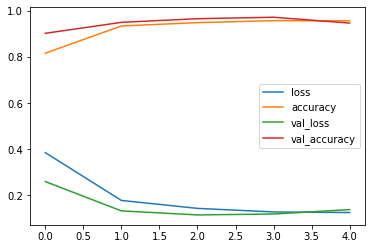

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[145  13]
 [  7 151]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.95      0.92      0.94       158
   PNEUMONIA       0.92      0.96      0.94       158

    accuracy                           0.94       316
   macro avg       0.94      0.94      0.94       316
weighted avg       0.94      0.94      0.94       316

*****  Metric Scores  *****
Accuracy :  0.937
Precision :  0.921
Recall   :  0.956
F1 score :  0.938
*****  Heat Map of Confusion Matrix  *****


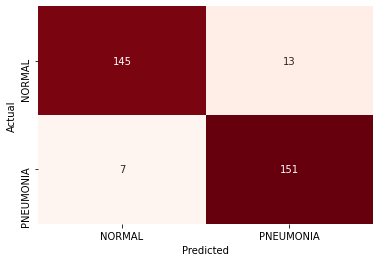

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 93s 957ms/step - loss: 0.3706 - accuracy: 0.8395 - val_loss: 0.1892 - val_accuracy: 0.9335
Epoch 2/25
96/96 [==============================] - 93s 968ms/step - loss: 0.1830 - accuracy: 0.9312 - val_loss: 0.1784 - val_accuracy: 0.9241
Epoch 3/25
96/96 [==============================] - 93s 971ms/step - loss: 0.1621 - accuracy: 0.9442 - val_loss: 0.1111 - val_accuracy: 0.9462
Epoch 4/25
96/96 [==============================] - 92s 960ms/step - loss: 0.1274 - accuracy: 0.9524 - val_loss: 0.1129 - val_accuracy: 0.9557
Epoch 5/25
96/96 [==============================] - 90s 939ms/step - loss: 0.1261 - accuracy: 0.9556 - val_loss: 0.1175 - val_accuracy: 0.9462
Epoch 6/25
96/96 [==============================] - 91s 946ms/step - loss: 0.1008 - accuracy: 0.9625 - val_loss: 0.0851 - val_accuracy: 0.9684
Epoch 7/25
96/96 [==============================] - 91s 947ms/step - loss: 0.0796 - accuracy: 0.9716 - val_loss: 0.1128 - val_accuracy: 0.9557

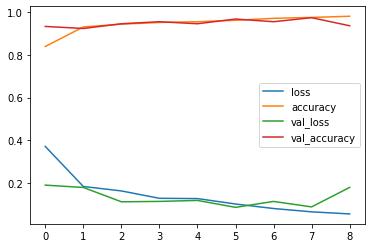

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[139  19]
 [  3 155]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.98      0.88      0.93       158
   PNEUMONIA       0.89      0.98      0.93       158

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316

*****  Metric Scores  *****
Accuracy :  0.930
Precision :  0.891
Recall   :  0.981
F1 score :  0.934
*****  Heat Map of Confusion Matrix  *****


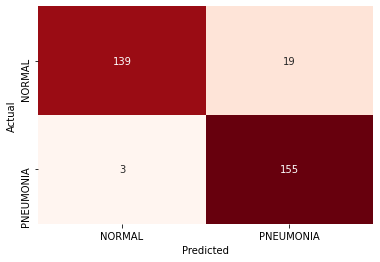

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 85s 876ms/step - loss: 0.3729 - accuracy: 0.8160 - val_loss: 0.1556 - val_accuracy: 0.9399
Epoch 2/25
96/96 [==============================] - 86s 897ms/step - loss: 0.1748 - accuracy: 0.9354 - val_loss: 0.2040 - val_accuracy: 0.9177
Epoch 3/25
96/96 [==============================] - 85s 890ms/step - loss: 0.1585 - accuracy: 0.9410 - val_loss: 0.1696 - val_accuracy: 0.9272
Epoch 4/25
96/96 [==============================] - 87s 904ms/step - loss: 0.1459 - accuracy: 0.9488 - val_loss: 0.1212 - val_accuracy: 0.9525
Epoch 5/25
96/96 [==============================] - 87s 911ms/step - loss: 0.1351 - accuracy: 0.9491 - val_loss: 0.1566 - val_accuracy: 0.9399
Epoch 6/25
96/96 [==============================] - 87s 908ms/step - loss: 0.1020 - accuracy: 0.9658 - val_loss: 0.1072 - val_accuracy: 0.9589
Epoch 7/25
96/96 [==============================] - 87s 907ms/step - loss: 0.0871 - accuracy: 0.9677 - val_loss: 0.2049 - val_accuracy: 0.9019

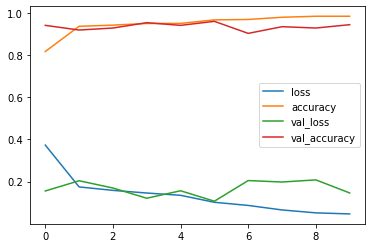

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[144  14]
 [  7 151]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.95      0.91      0.93       158
   PNEUMONIA       0.92      0.96      0.93       158

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316

*****  Metric Scores  *****
Accuracy :  0.934
Precision :  0.915
Recall   :  0.956
F1 score :  0.935
*****  Heat Map of Confusion Matrix  *****


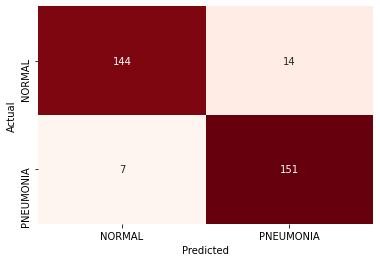

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 90s 937ms/step - loss: 0.3424 - accuracy: 0.8337 - val_loss: 0.1753 - val_accuracy: 0.9241
Epoch 2/25
96/96 [==============================] - 90s 938ms/step - loss: 0.1939 - accuracy: 0.9253 - val_loss: 0.1365 - val_accuracy: 0.9335
Epoch 3/25
96/96 [==============================] - 90s 938ms/step - loss: 0.1485 - accuracy: 0.9455 - val_loss: 0.1311 - val_accuracy: 0.9399
Epoch 4/25
96/96 [==============================] - 90s 941ms/step - loss: 0.1319 - accuracy: 0.9527 - val_loss: 0.1387 - val_accuracy: 0.9430
Epoch 5/25
96/96 [==============================] - 91s 944ms/step - loss: 0.1135 - accuracy: 0.9596 - val_loss: 0.1187 - val_accuracy: 0.9652
Epoch 6/25
96/96 [==============================] - 90s 940ms/step - loss: 0.1176 - accuracy: 0.9550 - val_loss: 0.1166 - val_accuracy: 0.9494
Epoch 7/25
96/96 [==============================] - 90s 941ms/step - loss: 0.0929 - accuracy: 0.9671 - val_loss: 0.1100 - val_accuracy: 0.9589

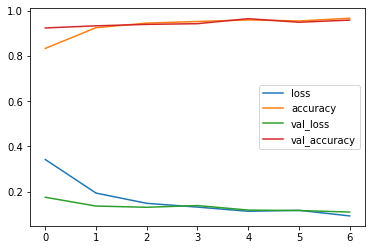

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[150   8]
 [  8 150]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       158
   PNEUMONIA       0.95      0.95      0.95       158

    accuracy                           0.95       316
   macro avg       0.95      0.95      0.95       316
weighted avg       0.95      0.95      0.95       316

*****  Metric Scores  *****
Accuracy :  0.949
Precision :  0.949
Recall   :  0.949
F1 score :  0.949
*****  Heat Map of Confusion Matrix  *****


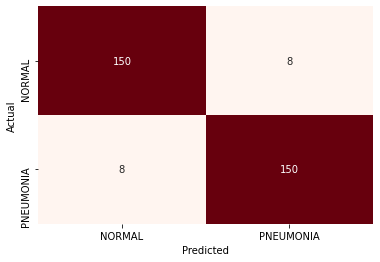

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 90s 939ms/step - loss: 0.3988 - accuracy: 0.7988 - val_loss: 0.1983 - val_accuracy: 0.9241
Epoch 2/25
96/96 [==============================] - 90s 935ms/step - loss: 0.1813 - accuracy: 0.9322 - val_loss: 0.2508 - val_accuracy: 0.8892
Epoch 3/25
96/96 [==============================] - 90s 936ms/step - loss: 0.1558 - accuracy: 0.9468 - val_loss: 0.1087 - val_accuracy: 0.9494
Epoch 4/25
96/96 [==============================] - 90s 934ms/step - loss: 0.1427 - accuracy: 0.9501 - val_loss: 0.1766 - val_accuracy: 0.9177
Epoch 5/25
96/96 [==============================] - 90s 935ms/step - loss: 0.1305 - accuracy: 0.9553 - val_loss: 0.1503 - val_accuracy: 0.9367

**************************************************
**********. Model run #:  8   **********


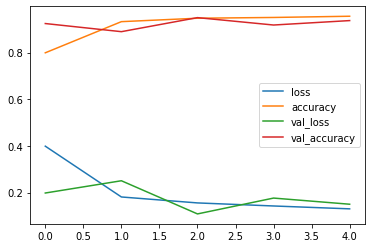

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[140  18]
 [  5 153]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.97      0.89      0.92       158
   PNEUMONIA       0.89      0.97      0.93       158

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316

*****  Metric Scores  *****
Accuracy :  0.927
Precision :  0.895
Recall   :  0.968
F1 score :  0.930
*****  Heat Map of Confusion Matrix  *****


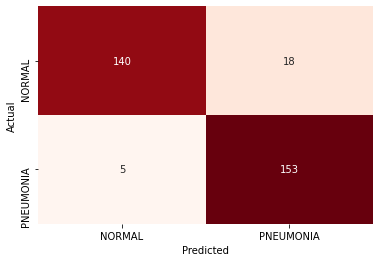

*****  Metrics Results  *****


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Epoch 1/25
96/96 [==============================] - 91s 944ms/step - loss: 0.5220 - accuracy: 0.7417 - val_loss: 0.4251 - val_accuracy: 0.9082
Epoch 2/25
96/96 [==============================] - 90s 936ms/step - loss: 0.2986 - accuracy: 0.9044 - val_loss: 0.2725 - val_accuracy: 0.8987
Epoch 3/25
96/96 [==============================] - 90s 936ms/step - loss: 0.1629 - accuracy: 0.9377 - val_loss: 0.1486 - val_accuracy: 0.9272
Epoch 4/25
96/96 [==============================] - 90s 936ms/step - loss: 0.1421 - accuracy: 0.9478 - val_loss: 0.1098 - val_accuracy: 0.9494
Epoch 5/25
96/96 [==============================] - 91s 945ms/step - loss: 0.1213 - accuracy: 0.9550 - val_loss: 0.1312 - val_accuracy: 0.9462
Epoch 6/25
96/96 [==============================] - 90s 940ms/step - loss: 0.1032 - accuracy: 0.9638 - val_loss: 0.1122 - val_accuracy: 0.9494
Epoch 7/25
96/96 [==============================] - 91s 947ms/step - loss: 0.0863 - accuracy: 0.9716 - val_loss: 0.1416 - val_accuracy: 0.9335

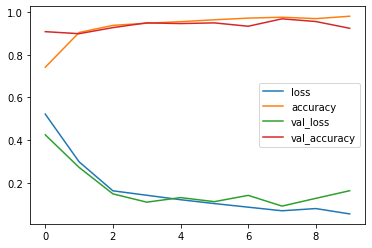

*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[140  18]
 [  4 154]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.97      0.89      0.93       158
   PNEUMONIA       0.90      0.97      0.93       158

    accuracy                           0.93       316
   macro avg       0.93      0.93      0.93       316
weighted avg       0.93      0.93      0.93       316

*****  Metric Scores  *****
Accuracy :  0.930
Precision :  0.895
Recall   :  0.975
F1 score :  0.933
*****  Heat Map of Confusion Matrix  *****


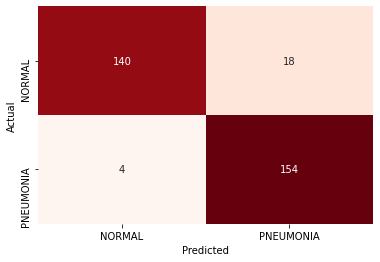

*****  Metrics Results  *****


In [20]:
for iteration in range(10):
# Call method to split arrays apart but still have y array with correct labels associated, verify sizes again
    X_train,y_train = shuffle_label_array(X_train,y_train)
    X_test,y_test = shuffle_label_array(X_test,y_test)
    X_valid,y_valid = shuffle_label_array(X_valid,y_valid)

    # Reshaping the X data
    # Reshape the data into (no of samples, height, width, 1) where 1 represents single color channel grayscale
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
    X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1)

    # Create the model
    model2 = Sequential()

    # Add model layers
    model2.add(Conv2D(32, (3,3),
                    activation='relu',
                    input_shape=(img_width, img_height, 1)))
    model2.add(MaxPooling2D((2,2)))
    # number of nodes in each layer - 32
    # activation - relu model for rectified linear
    # input_shape - pizel size of image
    # pool_size - reduce feature map by factor of 2, typically (2,2)

    # Add another model layer to further reduce shape
    model2.add(Conv2D(32, (3,3),
                    activation='relu',
                    input_shape=(img_width, img_height, 1)))
    model2.add(MaxPooling2D(pool_size = (2,2)))

    # Add another model layer to further reduce shape
    model2.add(Conv2D(64, (3,3),
                    activation='relu',
                    input_shape=(img_width, img_height, 1)))
    model2.add(MaxPooling2D(pool_size = (2,2)))      


    # Now flatten the layers
    model2.add(Flatten())

    # Use Dense to lower shape down to 1 output
    model2.add(Dense(64,activation ='relu'))
    model2.add(Dense(1,activation='sigmoid'))

    # Set a validation set of data to set early stopping point for model fit
    my_callbacks = [EarlyStopping(monitor='accuracy', mode='max', min_delta= 0.01, patience = 2)]

    # Compile the model
    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # fit the model and run
    history = model2.fit(X_train, y_train, epochs = 25, validation_data=(X_valid,y_valid), callbacks=my_callbacks)
    print("\n**************************************************")
    print("**********. Model run #: ",iteration,"  **********")
    pd.DataFrame(history.history).plot()
    plt.show()
    acc, prec, rec, f = model_results(model2,X_test,y_test)
    accuracy.append(acc)
    precision.append(prec)
    recall.append(rec)
    f1.append(f)

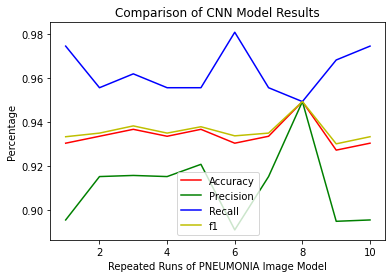

In [21]:
# plot metrics data
columns = np.arange(1,len(accuracy)+1)
plt.plot(columns, accuracy, label = "Accuracy", color='r')
plt.plot(columns, precision, label = "Precision", color='g')
plt.plot(columns, recall, label = "Recall", color='b')
plt.plot(columns, f1, label = "f1", color='y')
plt.legend()
plt.xlabel("Repeated Runs of PNEUMONIA Image Model")
plt.ylabel("Percentage")
plt.title("Comparison of CNN Model Results")
plt.show()

# Conclusion
Observe accuracy and model metrics variable range over 10 consequtive runs

In [22]:
from statistics import stdev

acc_range = max(accuracy) - min(accuracy)
acc_average = sum(accuracy)/len(accuracy)
prec_range = max(precision) - min(precision)
prec_average = sum(precision)/len(precision)
recal_range = max(recall) - min(recall)
recal_average = sum(recall)/len(recall)
print('******** ACCURACY DATA FROM RUNS ********')
print('Accuracy Average: ',' Average: ',f'{acc_average:.3f}')
print('Accuracy STD    : ',' Std Dev: ',f'{stdev(accuracy):.3f}')
print('******** ACCURACY DATA FROM RUNS ********')
print('Accuracy Range (Max,Min) : ',f'{max(accuracy):.2f}','/',f'{min(accuracy):.2f}','  Range: ',f'{acc_range:.2f}')
print('Precision Range (Max,Min): ',f'{max(precision):.2f}','/',f'{min(precision):.2f}','  Range: ',f'{prec_range:.2f}',' Average: ',f'{prec_average:.2f}')
print('Recall Range (Max,Min)   : ',f'{max(recall):.2f}','/',f'{min(recall):.2f}','  Range: ',f'{recal_range:.2f}',' Average: ',f'{recal_average:.2f}')
print('F1 Range (Max,Min)       : ',f'{max(f1):.2f}','/',f'{min(f1):.2f}')


******** ACCURACY DATA FROM RUNS ********
Accuracy Average:   Average:  0.934
Accuracy STD    :   Std Dev:  0.006
******** ACCURACY DATA FROM RUNS ********
Accuracy Range (Max,Min) :  0.95 / 0.93   Range:  0.02
Precision Range (Max,Min):  0.95 / 0.89   Range:  0.06  Average:  0.91
Recall Range (Max,Min)   :  0.98 / 0.95   Range:  0.03  Average:  0.96
F1 Range (Max,Min)       :  0.95 / 0.93
